<center>


<h3>States and Memory demonstrations</h3>
<ul>
<li><h3>State Schema </h3></li>
<li><h3>Branching(parallel execution) </h3></li>
<li><h3>State Reducer(prebuilt,custom) </h3></li>
<li><h3>Multiple Schemas </h3></li>
<li><h3>Filtering Trimming messages(Advance ways to work with Messages in Langgraph)</h3>

</li>
<li><h3>Saving State in Memory/external DB </h3></li>

</ul>

</center>

# State Schema 
<ul>
<li>When creating Graph we define StateGraph and we use State.</li>
<li>The State Schema represents the structure and type of data that our graph will use.</li>
<li>All Nodes are expected to communicate with that schema.</li>
</ul>
There are various ways we can define the type / structure of our schema.
<ul>
<li>TypedDict  (Not inforced at runtime)</li>
<li>DataClass (Not inforced at runtime)</li>
<li>Pydantic <code>(Enforced at runtime)</code></li>
</ul>
Use <code>Pydentic</code> to define states of graph as it is being implemeted at the runtime so that any unvalidated data won't go into the system.
Other than TypedDict or DataClass these are not being implemented at the run time.

In [1]:
from langchain_core.pydantic_v1 import BaseModel,validator,ValidationError
from typing import Literal

class PydanticState(BaseModel):
    name: str
    mood: Literal["happy","sad"]
    
    @validator('mood')
    def validate_mood(cls,value):
        if value in ["happy","sad"]:
            return value
        raise ValidationError("Mood should be in ['happy','sad'] ")
    
try:
    state = PydanticState(name="aditya",mood="mad")
except Exception as e:
    print(e)

1 validation error for PydanticState
mood
  unexpected value; permitted: 'happy', 'sad' (type=value_error.const; given=mad; permitted=('happy', 'sad'))


/Users/adityaanand/Desktop/Desktop/DataScience/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


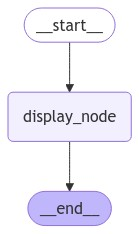

In [5]:
from langgraph.graph import START,END,StateGraph
from IPython.display import Image,display

def display_mood(state:PydanticState):
    return {'name':state.name,'mood':state.mood}

builder = StateGraph(PydanticState)
builder.add_node('display_node',display_mood)

builder.add_edge(START,'display_node')
builder.add_edge('display_node',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({'name':'Aditya','mood':'happy'})

{'name': 'Aditya', 'mood': 'happy'}

In [7]:
# Will throw error at execution time
graph.invoke({'name':'Aditya','mood':'good'})

ValidationError: 1 validation error for PydanticState
mood
  unexpected value; permitted: 'happy', 'sad' (type=value_error.const; given=good; permitted=('happy', 'sad'))

# <font color="green">State Reducer</font>
<p><strong>Branching</strong>,<strong>Reducer</strong>,<strong>add_message</strong>(reducer for MessagesState).</p></br>
State Reducer specify how state updates are performed on specific keys/channels in the state Schema.

In [8]:
# Normal State
from typing import TypedDict

class TestState(TypedDict):
    counter : int

# node
def update_counter(state:TestState):
    return {'counter':state['counter']+1}

builder = StateGraph(TestState)
builder.add_node('update_counter',update_counter)

builder.add_edge(START,'update_counter')
builder.add_edge('update_counter',END)

graph = builder.compile()


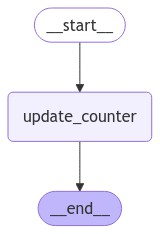

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({'counter':5})

{'counter': 6}

# Branching
<p>When our nodes branch, it might execute in parallel and are supposed to use same state.
When we update the same state in parallel it will throw error as graph dont knows which value to override first.</p>
<p>This is where we'll need <code>Reducer </code></p>
<p>Node running in prallel are the part of same graph execution.</p>
<p>By default Graph don't know how to update the State Schema so it <code>overrides</code> it.</p>


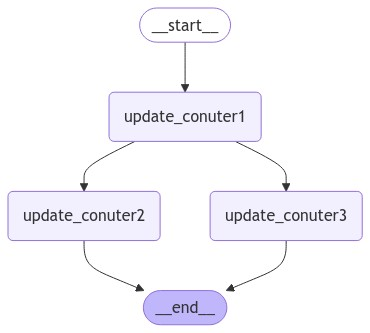

In [11]:
# nodes
def update_counter1(state:TestState):
    return {'counter':state['counter']+1}


def update_counter2(state:TestState):
    return {'counter':state['counter']+1}


def update_counter3(state:TestState):
    return {'counter':state['counter']+1}

builder = StateGraph(TestState)
builder.add_node('update_conuter1',update_counter1)
builder.add_node('update_conuter2',update_counter2)
builder.add_node('update_conuter3',update_counter3)

builder.add_edge(START,'update_conuter1')
builder.add_edge('update_conuter1','update_conuter2') #parallel to node 'update_conuter3'
builder.add_edge('update_conuter1','update_conuter3') #parallel to node 'update_conuter2'
builder.add_edge('update_conuter2',END)
builder.add_edge('update_conuter3',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


This is where we need reducers

In [12]:
# InvalidUpdateError: At key 'counter': Can receive only one value per step
from langgraph.errors import InvalidUpdateError
try:
 graph.invoke({'counter':5})
except InvalidUpdateError as e:
    print(e)


At key 'counter': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


# Reducers
<ul>
<li>Predefined Reducer</li>
<li>Custom Reducer</li>
</ul>

Predefined Reducer

In [13]:
# update the state schema and give reducer function at the time of defining
from operator import add
from typing import Annotated

class TestState(TypedDict):
    counter : Annotated[list[int],add]  # Here add is a predefined function in python that has been used as reducer




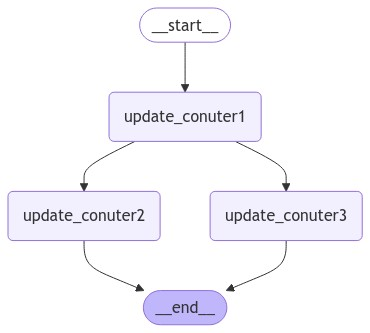

In [14]:
# nodes
def update_counter1(state:TestState):
    print("_________________________________")
    print("---- Node 1 ----")
    print("State : ",state)
    value = {'counter':[state['counter'][0]+1]}
    print("After updating state : ",state['counter']+[state['counter'][0]+1])
    return value


def update_counter2(state:TestState):
    print("_________________________________")
    print("---- Node 2 ----")
    print("State : ",state)
    value = {'counter':[state['counter'][0]+1]}
    print("After updating state : ",state['counter']+[state['counter'][0]+1])
    
    return value


def update_counter3(state:TestState):
    print("_________________________________")
    print("---- Node 3 ----")
    print("State : ",state)
    value = {'counter':[state['counter'][0]+1]}
    print("After updating state : ",state['counter']+[state['counter'][0]+1])
    
    return value

builder = StateGraph(TestState)
builder.add_node('update_conuter1',update_counter1)
builder.add_node('update_conuter2',update_counter2)
builder.add_node('update_conuter3',update_counter3)

builder.add_edge(START,'update_conuter1')
builder.add_edge('update_conuter1','update_conuter2') #parallel to node 'update_conuter3'
builder.add_edge('update_conuter1','update_conuter3') #parallel to node 'update_conuter2'
builder.add_edge('update_conuter2',END)
builder.add_edge('update_conuter3',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
print("\n\nfinal output from graph : " ,graph.invoke({'counter':[5]}))

_________________________________
---- Node 1 ----
State :  {'counter': [5]}
After updating state :  [5, 6]
_________________________________
---- Node 2 ----
State :  {'counter': [5, 6]}
After updating state :  [5, 6, 6]
_________________________________
---- Node 3 ----
State :  {'counter': [5, 6]}
After updating state :  [5, 6, 6]


final output from graph :  {'counter': [5, 6, 6, 6]}


# Expecting Error

In [16]:

print("\n\nfinal output from graph : " ,graph.invoke({'counter':None}))

TypeError: can only concatenate list (not "NoneType") to list

<strong>Custom Reducer</strong>
<p>What if we ran into error or passed some invalid data inside prebuilt reducer.</p>
<p>To handle it we need to define our own reducer sometime. </p>
<p>When we want somemore way to handle/update the state. </p>

In [17]:
def validated_reducer(prev_list: list| None, new_list: list | None):
    if prev_list is None:
        prev_list = []
    if new_list is None:
        new_list = []
    return prev_list + new_list

class TestState(TypedDict):
    counter : Annotated[list[int],validated_reducer]


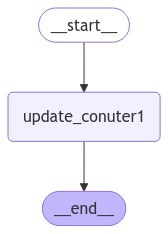

In [18]:
# nodes
def update_counter1(state:TestState):
    print("_________________________________")
    print("---- Node 1 ----")
    print("State : ",state)
    value = {'counter':[10]}
    print("After updating state : ",validated_reducer(state['counter'],[10]))
    return value


    return value
builder = StateGraph(TestState)
builder.add_node('update_conuter1',update_counter1)


builder.add_edge(START,'update_conuter1')
builder.add_edge('update_conuter1',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
print("\n\nfinal output from graph : " ,graph.invoke({'counter':None}))

_________________________________
---- Node 1 ----
State :  {'counter': []}
After updating state :  [10]


final output from graph :  {'counter': [10]}


### <font color="red">add_messages</font> reducer
<p>When we pass ID to add_message reducer it updates the message which has same id.</p>

In [21]:
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from langgraph.graph.message import add_messages

messages = [HumanMessage(content="Hey ,how are you?",id=1),AIMessage(content="Hey I am doing good.",id=2)]
new_message = [AIMessage(content="Thanks for asking",id=3)]

add_messages(messages,new_message)


[HumanMessage(content='Hey ,how are you?', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Hey I am doing good.', additional_kwargs={}, response_metadata={}, id='2'),
 AIMessage(content='Thanks for asking', additional_kwargs={}, response_metadata={}, id='3')]

In [22]:
messages = [HumanMessage(content="Hey ,how are you?",id=1),AIMessage(content="Hey I am doing good.",id=2)]
new_message = [AIMessage(content="Hey I am doing good.Thanks for asking.",id=2)]

add_messages(messages,new_message)

[HumanMessage(content='Hey ,how are you?', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Hey I am doing good.Thanks for asking.', additional_kwargs={}, response_metadata={}, id='2')]

Removal of messages

In [23]:
# Delete messages using Delete Message
from langchain_core.messages import RemoveMessage
messages = [SystemMessage(content="You are a smart assistance with good suggestions skills.",id="2323"),HumanMessage(content="Hey ,how are you?",id=1),AIMessage(content="Hey I am doing good.",id=2),AIMessage(content="Thanks for asking",id=3),HumanMessage(content="Tell me about oceans",id=4)]
messages

[SystemMessage(content='You are a smart assistance with good suggestions skills.', additional_kwargs={}, response_metadata={}, id='2323'),
 HumanMessage(content='Hey ,how are you?', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Hey I am doing good.', additional_kwargs={}, response_metadata={}, id='2'),
 AIMessage(content='Thanks for asking', additional_kwargs={}, response_metadata={}, id='3'),
 HumanMessage(content='Tell me about oceans', additional_kwargs={}, response_metadata={}, id='4')]

In [24]:
delete_messages = [RemoveMessage(m.id) for m in messages[:-2]]
delete_messages

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2323'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]

#### add_message will also delete the messages if RemoveMessage is proved

In [25]:
add_messages(messages,delete_messages)

[AIMessage(content='Thanks for asking', additional_kwargs={}, response_metadata={}, id='3'),
 HumanMessage(content='Tell me about oceans', additional_kwargs={}, response_metadata={}, id='4')]

# Multiple Schemas
Typically all graph node communicate with a single schema
also single schema contains graph input and output keys/channel.

But there are cases where we may want more control over this.
<ul>
<li>Internal node may pass infromation that is not required in the graph input/output. </li>
<li>We may also want the different Input/Output schema for graph. </li>
</ul>
<p>Customizing Graph with multiple schmea </p>


Private State

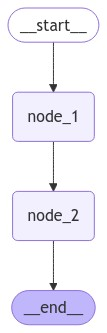

In [34]:
from typing import TypedDict
class PrivateState(TypedDict):
    counter: int
class OverAllState(TypedDict):
    input : int
    output: int

    
def node1(state : OverAllState)-> PrivateState: # giving output as Private State, then can use this private information into another node.
    return {'counter':state['input']+2}
def node2(state : PrivateState)-> OverAllState:  # Accessing private information.
    return {'output':state['counter']+1}

builder = StateGraph(OverAllState)
builder.add_node('node_1',node1)
builder.add_node('node_2',node2)

builder.add_edge(START,'node_1')
builder.add_edge('node_1','node_2')
builder.add_edge('node_2',END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
graph.invoke({'input' : 10})

{'input': 10, 'output': 13}

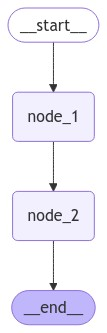

In [41]:
from typing import TypedDict


class InputState(TypedDict):
    input:int
    
class OutputState(TypedDict):
    output:int
    
    
class PrivateState(TypedDict):
    counter: int
    
    
class OverAllState(TypedDict):
    input : int
    output: int

    
def node1(state : InputState)-> PrivateState: # giving output as Private State, then can use this private information into another node.
    return {'counter':state['input']+2}
def node2(state : PrivateState)-> OutputState:  # Accessing private information.
    return {'output':state['counter']+1}

builder = StateGraph(OverAllState,input=InputState,output=OutputState)
# builder = StateGraph(OverAllState,output=OutputState)
builder.add_node('node_1',node1)
builder.add_node('node_2',node2)

builder.add_edge(START,'node_1')
builder.add_edge('node_1','node_2')
builder.add_edge('node_2',END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
graph.invoke({'input' : 10})

{'output': 13}

# Filtering Trimming messages
Advance ways to work with Messages in Langgraph.

In [45]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import RemoveMessage,SystemMessage,HumanMessage,AIMessage
from langgraph.graph.message   import MessagesState,add_messages
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")
messages = [SystemMessage(content="You are a smart assistance with good suggestions skills.",id=2323),HumanMessage(content="Hey ,how are you?",id=1),AIMessage(content="Hey I am doing good.",id=2),AIMessage(content="Thanks for asking",id=3),HumanMessage(content="I want to know about oceans.Tell me interesting things.",id=4)]


Deleting messages

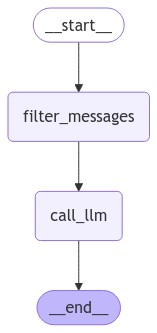

In [58]:
# Delete messages.

# Agent

#node
def delete_messages(state:MessagesState):
    print("------- Deleting Messages leaving recent one --------\n")
    messages_for_chat = [RemoveMessage(m.id) for m in state['messages'][:-1]]
    value = {'messages':messages_for_chat}
    return value



def call_llm(state:MessagesState):
    print("------ Calling LLM for response----\n")
    print("message to llm : ",state['messages'],"\n")
    # return {'messages':llm.invoke(state['messages'])} # uncomment it to call LLM

#building Graph
builder = StateGraph(MessagesState)
builder.add_node("updated_messages",delete_messages)
builder.add_node("call_llm",call_llm)
builder.add_edge(START,"updated_messages")
builder.add_edge('updated_messages','call_llm')
builder.add_edge('call_llm',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [59]:
reponse = graph.invoke({'messages':messages})
for message in reponse['messages']:
    print(message.pretty_print())

------- Deleting Messages leaving recent one --------

------ Calling LLM for response----

message to llm :  [HumanMessage(content='I want to know about oceans.Tell me interesting things.', additional_kwargs={}, response_metadata={}, id='4')] 

================================ Human Message =================================

I want to know about oceans.Tell me interesting things.
None
================================== Ai Message ==================================

Sure! Oceans are fascinating and play a crucial role in our planet's health and climate. Here are some interesting facts about oceans:

1. **Coverage**: Oceans cover about 71% of the Earth's surface, with the Pacific Ocean being the largest, followed by the Atlantic, Indian, Southern, and Arctic Oceans.

2. **Depth**: The average depth of the oceans is about 12,080 feet (3,682 meters). The deepest part, the Mariana Trench, reaches about 36,000 feet (over 10,900 meters) deep.

3. **Biodiversity**: Oceans are home to an incre

In [60]:
reponse

{'messages': [HumanMessage(content='I want to know about oceans.Tell me interesting things.', additional_kwargs={}, response_metadata={}, id='4'),
  AIMessage(content='Sure! Oceans are fascinating and play a crucial role in our planet\'s health and climate. Here are some interesting facts about oceans:\n\n1. **Coverage**: Oceans cover about 71% of the Earth\'s surface, with the Pacific Ocean being the largest, followed by the Atlantic, Indian, Southern, and Arctic Oceans.\n\n2. **Depth**: The average depth of the oceans is about 12,080 feet (3,682 meters). The deepest part, the Mariana Trench, reaches about 36,000 feet (over 10,900 meters) deep.\n\n3. **Biodiversity**: Oceans are home to an incredible diversity of life. It\'s estimated that around 230,000 marine species have been described, but scientists believe that there could be over 2 million species yet to be discovered.\n\n4. **Oxygen Production**: Phytoplankton, tiny marine plants, produce about 50% of the Earth\'s oxygen throu

Filter messages 

In [ ]:
#node

def call_llm(state:MessagesState):
    ("------- filtering Messages leaving recent one(send only current message) --------\n")
    print("------ Calling LLM for response----\n")
    print("message to llm : ",state['messages'][-1:],"\n")
    # return {'messages':llm.invoke(state['messages'][-1:])} # uncomment it to call LLM

#building Graph
builder = StateGraph(MessagesState)
builder.add_node("call_llm",call_llm)
builder.add_edge(START,"call_llm")
builder.add_edge('call_llm',END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [80]:
reponse = graph.invoke({'messages':messages})
for message in reponse['messages']:
    print(message.pretty_print())

------ Calling LLM for response----

message to llm :  [HumanMessage(content='I want to know about oceans.Tell me interesting things.', additional_kwargs={}, response_metadata={}, id='4')] 

================================ System Message ================================

You are a smart assistance with good suggestions skills.
None
================================ Human Message =================================

Hey ,how are you?
None
================================== Ai Message ==================================

Hey I am doing good.
None
================================== Ai Message ==================================

Thanks for asking
None
================================ Human Message =================================

I want to know about oceans.Tell me interesting things.
None
================================== Ai Message ==================================

Oceans are vast and fascinating bodies of water that cover about 71% of the Earth's surface. Here are some interesting fac

In [70]:
messages[-1]

HumanMessage(content='I want to know about oceans.Tell me interesting things.', additional_kwargs={}, response_metadata={}, id='4')

Trimming messages

In [6]:
from langchain_core.messages import trim_messages
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage
messages = [
                SystemMessage("you're a good assistant, you always respond with a joke."),
                HumanMessage("i wonder why it's called langchain"),
                AIMessage(
                    'Well, I guess they thought "WordRope" and "SentenceString" just didn\'t have the same ring to it!'
                ),
                HumanMessage("and who is harrison chasing anyways"),
                AIMessage(
                    "Hmmm let me think.\n\nWhy, he's probably chasing after the last cup of coffee in the office!"
                ),
                HumanMessage("what do you call a speechless parrot"),
            ]
trimmed_message = trim_messages(
                messages,
                # When `len` is passed in as the token counter function,
                # max_tokens will count the number of messages in the chat history.
                max_tokens=3,
                strategy="last",
                # Passing in `len` as a token counter function will
                # count the number of messages in the chat history.
                token_counter=len,
                # Most chat models expect that chat history starts with either:
                # (1) a HumanMessage or
                # (2) a SystemMessage followed by a HumanMessage
                start_on="human",
                # Usually, we want to keep the SystemMessage
                # if it's present in the original history.
                # The SystemMessage has special instructions for the model.
                include_system=True,
                allow_partial=False,
            )

In [7]:
trimmed_message

[SystemMessage(content="you're a good assistant, you always respond with a joke.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='what do you call a speechless parrot', additional_kwargs={}, response_metadata={})]

# Chat Bot with MessageSummarization
<p>Rather than trimming or filtering the messages, let's use LLM to produce running summary of the conversatation.</p>
<p>The allow us to have the compressed representation of the of the full conversatation, rather than just removing it with trimming or filtering.</p>
<p>We'll incorporate this summarization into a simple chat bot.</p>
<p>And we'll also enquipt the chatbot with memory , supporting long running-conversatation without incurring high token cost/latency.</p>

In [8]:
from langchain_openai import ChatOpenAI
from langgraph.graph.message import MessagesState
from langchain_core.messages import HumanMessage,SystemMessage,RemoveMessage
from dotenv import load_dotenv

load_dotenv()

llm = ChatOpenAI(model = 'gpt-4o-mini')

class State(MessagesState):
    summary : str

# nodes
def call_model(state:State):
    summary = state.get("summary","")
    if summary:
        # if previous summary available
        prev_summary = f"summary of the conversatation earlier : {summary}"
        
        messages = [SystemMessage(content=prev_summary) + state['messages']]
    else:
        messages = state['messages']
    response = llm.invoke(messages)
    
    return {"messages" : response}

def create_summary(state : State):
    summary = state.get("summary","")
    if summary:
        summary_message = f"This is the summary of the previous conversatation : {summary}.\n\n Extend the summary by taking the new message above."
    else:
        summary_message = "Create the summary of the conversatation above."
    messages = state['messages']+[HumanMessage(content=summary_message)]
    response  = llm.invoke(messages)
    
    # shortening the messages
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    
    return {"summary":response.content , "messages":delete_messages}
    



### Adding Memory to Graph

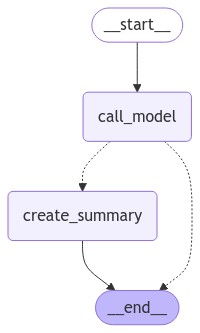

In [14]:
from langgraph.graph import START,END,StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display,Image

#conditional edge
def conditional_create_summary(state:State):
    if len(state['messages']) > 3:
        return 'create_summary'
    else:
        return END

# defining graph
builder = StateGraph(State)
builder.add_node('call_model',call_model)
builder.add_node('create_summary',create_summary)

builder.add_edge(START,'call_model')
builder.add_conditional_edges('call_model',conditional_create_summary)
builder.add_edge('create_summary',END)

memory = MemorySaver()


graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


#### About Theread
<p>Checkpointer save the state at each step as a checkpoint.</p>
<p>The saved checkpoint can be grouped into a thread of conversatation.</p>

In [15]:
config = {"configurable":{"thread_id":1}}

output = graph.invoke({"messages" : [HumanMessage(content="Hey my name is Aditya")]},config)


In [16]:
output


{'messages': [HumanMessage(content='Hey my name is Aditya', additional_kwargs={}, response_metadata={}, id='67eac5a3-86cb-4035-b706-8a80ce2496e4'),
  AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-78c86e4d-7859-4c33-8618-bdc83af09073-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}

In [17]:
output = graph.invoke({"messages" : [HumanMessage(content="what is my name?")]},config)
output

{'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='3cc4a8ab-5de1-4c83-b008-9d637788bbb8'),
  AIMessage(content='Your name is Aditya. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 37, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-41e698d4-ba15-4ada-a3b7-e39fa46a1013-0', usage_metadata={'input_tokens': 37, 'output_tokens': 13, 'total_tokens': 50, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})],
 'summary': 'In the conversation, Aditya introduces himself and asks what his name is. I respond by confirming that his name is Aditya and offer assistance for the day

## <font color="green">Storing in external database</font>
save thread in our SQLlite db we can also use Postgres


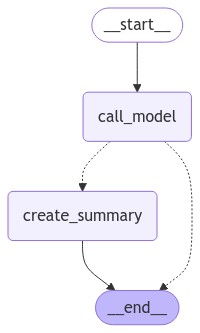

In [6]:
import sqlite3
# connect to a database and using RAM
# conn = sqlite3.connect(":memory:") # it will create  in memory sqllit-db. 
path = "example.db"
conn = sqlite3.connect(path,check_same_thread=False)


from langgraph.graph import START,END,StateGraph
from IPython.display import display,Image
from langchain_openai import ChatOpenAI
from langgraph.graph.message import MessagesState
from langchain_core.messages import HumanMessage,SystemMessage,RemoveMessage
from dotenv import load_dotenv

load_dotenv()

llm = ChatOpenAI(model = 'gpt-4o-mini')

# using external DB
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)



class State(MessagesState):
    summary : str

# nodes

#conditional edge
def conditional_create_summary(state:State):
    if len(state['messages']) > 3:
        return 'create_summary'
    else:
        return END

# nodes
def call_model(state:State):
    summary = state.get("summary","")
    if summary:
        # if previous summary available
        prev_summary = f"summary of the conversatation earlier : {summary}"
        
        messages = [SystemMessage(content=prev_summary) + state['messages']]
    else:
        messages = state['messages']
    response = llm.invoke(messages)
    
    return {"messages" : response}

def create_summary(state : State):
    summary = state.get("summary","")
    if summary:
        summary_message = f"This is the summary of the previous conversatation : {summary}.\n\n Extend the summary by taking the new message above."
    else:
        summary_message = "Create the summary of the conversatation above."
    messages = state['messages']+[HumanMessage(content=summary_message)]
    response  = llm.invoke(messages)
    
    # shortening the messages
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    
    return {"summary":response.content , "messages":delete_messages}
    



# defining graph
builder = StateGraph(State)
builder.add_node('call_model',call_model)
builder.add_node('create_summary',create_summary)

builder.add_edge(START,'call_model')
builder.add_conditional_edges('call_model',conditional_create_summary)
builder.add_edge('create_summary',END)

# memory = MemorySaver()


graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
config = {"configurable":{"thread_id":1}}

In [11]:
output = graph.invoke({"messages" : [HumanMessage(content="Hey my name is Aditya")]},config)

In [11]:
output

{'messages': [HumanMessage(content='Hey my name is Aditya', additional_kwargs={}, response_metadata={}, id='cc02797f-3149-4be6-91ed-d3118366e8ed'),
  AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-0f527e9c-cce6-454d-810a-a94d0bb0c862-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}

In [24]:
output = graph.invoke({"messages" : [HumanMessage(content="what is my name?")]},config)
output

{'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='429f1e90-9ce9-4dec-b0a5-febccb29fbaf'),
  AIMessage(content='Your name is Aditya! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 37, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-15839b47-3e86-4982-b095-3cedb06beaf7-0', usage_metadata={'input_tokens': 37, 'output_tokens': 13, 'total_tokens': 50, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})],
 'summary': 'In the conversation, Aditya introduces himself and asks for confirmation of his name. I acknowledge his name and offer assistance.'}

# To check the saved state in db
1. Restart the kernal
2. Run the graph where sqllite as checkpointer
3. check the graph state with thread id.

In [8]:
config = {"configurable":{"thread_id":1}}
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hey my name is Aditya', additional_kwargs={}, response_metadata={}, id='1f30852e-a7ff-4d5f-938c-f072d4c9b68c'), AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-1f65811c-730d-4b56-8ef4-4eca4781d05d-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef90139-bd70-62e6-8001-a939052a706b'}}, metadata={'source'